In [1]:
import sys
sys.path.append("../../")
from BDA.stats import *
from BDA.plots import *

now importing: 
1. numpy as np 
2. from scipy import stats


now importing: 
3. matplotlib.pyplot as plt



Survival analysis is the data analysis of time to event data such as death/failure. This type of data can be (i) time until death after diagnosis of disease, (ii) time until a set of lightbulbs burn out.

The analysis of this data focuses on summarizing the main features of the distribution, such as median and other percentiles of time to failure, and on examining the effects of explanatory variables. Data on times until failure, or more optimistically, duration of survival or survival times, have two important features:

a. times are positive (non-negative) and typically have skewed distributions with long tails (think exponential distribution)

b. some of the subjects may survive beyond the study period (or period of observation). Some subjects may drop-out before we are able to observe how long they survive; we may only partially observe these subjects

c. Another type of censoring is when a person's true survival time is less than what we observed. Say a person caught a disease months before actually diagnosed.

Points b and c refer to left- and right-censoring. Censoring complicates all of the technical issues involved in analyzing the data. 

In 

In [2]:
duration = rexp(1000)
# help(rexp)

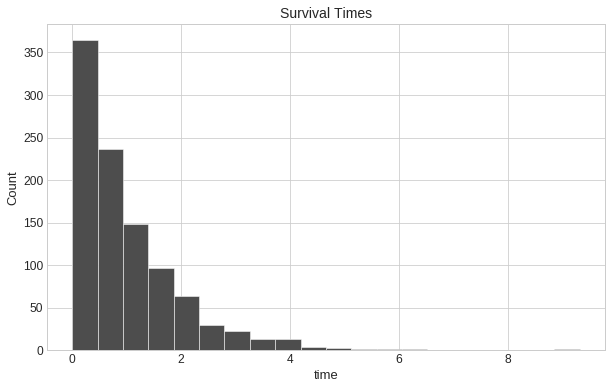

In [3]:
hist(duration, bins=20, title="Survival Times", xlabel="time", ylabel = "Count", density=False)

In [4]:
help(rexp)

Help on function rexp in module BDA.stats:

rexp(n, rate=None, loc=0, scale=1, log=False)



Since survival data are characterised by positive values and skewed distributions with long tails, we'll be looking at the Exponential, Weibull or Gamma distributions for our data models.

A few things to consider:

- time will refer to minutes, hours, days, years

- event can refer to death, disease incidence, or any other event of interest

- multiple events can be analyzed simultaneously; these types of models are refered to as competing risk models, but we will not delve into these models

In survival analysis we usually refer to the time variable as survival time, because it gives the time that an individual has "survived" over some follow-up period. We also, typically refer to the event as a failure because the event of interst is usually some negative event like death.


Most survival analyses must consider handling censored data. Essentially, for some groups of observations, we may not know the exact survival time.

In our notation, we will denote the random variable with a capital *T* and the observed/specific time value with a lower case *t*.

We denote the small letter d, $d \in (0,1)$, as a random variable indicating censorship. That is, if $d = 1$, then the observation was censored (i.e. only partially observed).

A focus for suvival analysis is in estimating the survivor function, $S(t)$, and the hazard function, $h(t)$.

If we are talking about people, the survivor function is simply the probability that a person survives longer than some time $t$,

$$
S(t) = P(T > t) = 1 - F(t)
$$

Recall that

$$
F(t) = \int_{0}^t f(u) du
$$


The hazard function is a rate function, defined as 

$$
\begin{aligned}
h(t) & = \lim_{\delta t \to 0}  \frac{P(t \leq T < t + \delta t | T > t)}{\delta t} \\
\ & =  \lim_{\delta t \to 0}   \frac{P(t \leq T < t + \delta t)}{\delta t} \times \frac{1}{P(T > t)} \\
\ & =  \lim_{\delta t \to 0}   \frac{S(t + \delta t) - S(t)}{\delta t} \times \frac{1}{S(t)} \\
\ & = - \frac{S'(t)}{S(t)}\\
\end{aligned}
$$

The relationship between the survival function and hazard function can be written as

$$
S(t) = exp\left[ - \int_0^t h(u) du \right] = exp\left[ - H(t) \right]
$$

where $H(t) = \int_0^t h(u) du$. The relationship between hazard and survival functions can also be written as

$$
h(t) = - \left[ \frac{d S(t)}{S(t)} \right]
$$


The first formula describes how the survivor function equals the exponential of the negative integral of the hazard function between integration limits of 0 and t.

The second describes how the hazard function equals negative the derivative of $S(t)$ with respec to t divided by $S(t)$.

Thus, if you know either the survivor function or hazard function, you can estimate the other.

## Empirical surivifor function

Just as we can estimate the empirical CDF, $\hat{F}(t)$, we can estimate the empirical surivivor function $\hat{S}(t)$.

$$
\hat{S}(t_i) = \prod_{j=1}^k \left( \frac{n_j - d_j}{n_j} \right)
$$

So, for each time $t_i$, we are simply looking for the proportion of survivors.

Consider the following example


In [5]:
from collections import namedtuple

survival = namedtuple('Survival', ['time', 'censored'], verbose=False) ## set True if you want to see code

times = [6, 6, 6, 6, 7, 9, 10, 10, 11, 13, 16,
        17, 19, 20, 22, 23, 25, 32, 32, 34, 35]

censored = [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

treated = [survival(t,d) for t,d in zip(times, censored)]

In [6]:
treated

[Survival(time=6, censored=0),
 Survival(time=6, censored=0),
 Survival(time=6, censored=0),
 Survival(time=6, censored=1),
 Survival(time=7, censored=0),
 Survival(time=9, censored=1),
 Survival(time=10, censored=0),
 Survival(time=10, censored=1),
 Survival(time=11, censored=1),
 Survival(time=13, censored=0),
 Survival(time=16, censored=0),
 Survival(time=17, censored=1),
 Survival(time=19, censored=1),
 Survival(time=20, censored=1),
 Survival(time=22, censored=0),
 Survival(time=23, censored=0),
 Survival(time=25, censored=1),
 Survival(time=32, censored=1),
 Survival(time=32, censored=1),
 Survival(time=34, censored=1),
 Survival(time=35, censored=1)]

In [16]:
def KP_estimate(data, verbose=False):
    ## create bins from non-censored data
    tmp = list(set([x.time for x in treated if x.censored == 0]))
    a = 0
    bins = []
    
    while tmp:
        b = tmp.pop(0)
        bins.append((a,b))
        a = b
    bins.append((a, np.inf))
    
    total_survivors = []
    surv_rate = 1
    for a, b in bins:
        alive, dead = check_alive(a,b, data, verbose=verbose)
        surv_rate *= (1 - dead/alive)
        total_survivors.append((a,b, alive, dead, round(surv_rate, 3)))
    return total_survivors


def check_alive(a, b, data, verbose = False):
    dead = 0
    alive = 0 ## previously alive
    for time, censored in data:
        result = (a <= time) and (time < b) and (censored == 0)
        if result:
            dead += 1
        if time >= a:
            alive +=1
        if verbose:
            print(f"{a} - <{b}: ({time}, {censored}) : {alive}, {dead}")
    #print(alive, dead)
    return (alive, dead)
        

KP_results = KP_estimate(treated, verbose=False) ## set true if you want to see detailed results

[print(line) for line in KP_results]

(0, 6, 21, 0, 1.0)
(6, 7, 21, 3, 0.857)
(7, 10, 17, 1, 0.807)
(10, 13, 15, 1, 0.753)
(13, 16, 12, 1, 0.69)
(16, 22, 11, 1, 0.627)
(22, 23, 7, 1, 0.538)
(23, inf, 6, 1, 0.448)


[None, None, None, None, None, None, None, None]

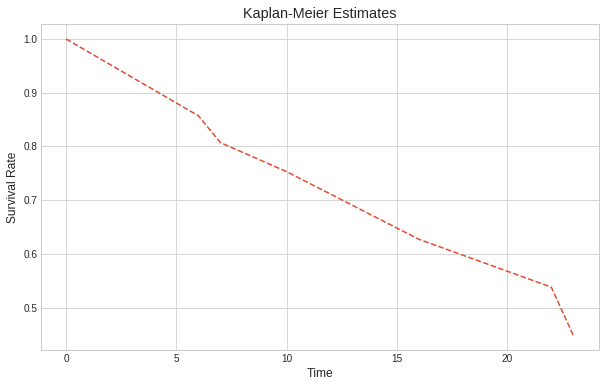

In [15]:
from BDA import Kaplan_Meier

surv = Kaplan_Meier.Survival(times, censored)
surv.plot()

## Exponential distribution

The simplest model for survival time $T$ is the exponential distribution with probability density function

$$
f(t | \theta) = \theta \times e^{-\theta t} \text{ , } t \geq 0 \text{ , } \theta > 0
$$

The cummulative distribution is 

$$
F(t) = \int_{0}^{t} \theta \times e^{-\theta u} du = 1 - e^{- \theta t}
$$

So the survivor function is $S(t) = 1 - F(t) = 1 - 1 + e^{- \theta t} = e^{- \theta t}$.

The hazard function is $h(t) = \theta$ and the cumulative hazard function is $H(t) = \theta t$


The benefit of using an exponential distribution is the *memoryless* (or lack of memory) property,

$$
P(T > t + \mu | T > \mu) =  P(T > t )
$$


## Proportional hazards models

For an exponential distribution, the dependence of Y on explanatory variables could be modelled as 

$$
E(Y) = \mathbf{x}^T \mathbf{\beta}
$$

where $\mathbf{x} = (x_0, ..., x_m)^T$ and $\mathbf{\beta} = (\beta_0, ..., \beta_m)$; $x_0 = 1$ is the bias term for the model matrix.

To ensure that $\theta > 0$, however, it is more common to use 

$$
\theta = exp(\mathbf{x}^T \mathbf{\beta})
$$

In this case the hazard function has the multiplicative form 

$$
h(t) = \theta = exp(\mathbf{x}^T \mathbf{\beta})
$$


For a binary explanatory variable $x_j, with 0 if the exposure/risk is absent and 1 if present, then the hazard ratio or relative hazard  is

$$
\frac{h_1(t | x_j = 1)}{h_0(t | x_j = 0)} = e^{\beta_j}
$$

A one-unit change in a continuous explanatory variable $x_k$ will also result in the hazard ratio given above.

More generally, models of the form 

$$
h_1(t) = h_0(t) exp(\mathbf{x}^T \mathbf{\beta})
$$

are called proportional hazards models and $h_0(t)$, which is the hazard function corresponding to the reference levels for all the explanatory variables, is called the *baseline hazard*.


